In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=1
env: OMP_NUM_THREADS=16


In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606886386871338

In [4]:
from transformers import AutoModelForCausalLM

MODEL_PATH = 'meta-llama/Meta-Llama-3.1-8B'
MODEL_SEQLEN = 8192

model_pt = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True, torch_dtype="auto", device_map='cpu',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from eval import *

testloader = get_loaders(
    'wikitext2',
    seed=0,
    model_path=MODEL_PATH,
    seqlen=MODEL_SEQLEN,
    eval_mode=True,
    use_fast_tokenizer=False,
    trust_remote_code=False,
)

def eval_ppl(
    model,
    model_path=MODEL_PATH,
    model_seqlen=MODEL_SEQLEN,
    device = 'cuda:0',
    # ppl_datasets = ('wikitext2',),
    trust_remote_code=False,
    offload_activations=False,
):
    output = {}
    
    ppl = perplexity_eval(
        model,
        testloader,
        dataset_name='wikitext2',
        model_seqlen=model_seqlen,
        device=device,
        offload_activations=offload_activations,
    )
    output['wikitext2'] = ppl
    # make sure that the cache is released
    torch.cuda.empty_cache()
    
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


In [18]:
import torch
from hqq.core.quantize import Quantizer as HqqQuantizer

@torch.no_grad()
def quantize_dequantize_hqq(weight, bits, group_size=64):    
    return HqqQuantizer.dequantize(*HqqQuantizer.quantize(
        weight,
        nbits=bits, group_size=group_size,
    ))


In [9]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [10]:
print(total_params)

6979584000


In [11]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [12]:
# data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LAYER_GALQIWI_PPL')
# data_df.to_csv('blockwise_slopes.csv')
data_df = pd.read_csv('blockwise_slopes.csv')

data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer_idx', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

from sklearn.linear_model import LinearRegression


slopes = []
intercepts = []

for layer_idx in range(32):
    to_fit = data_df[data_df['layer_idx'] == layer_idx]
    to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    # to_fit = to_fit[to_fit['wikitext2'] < 5.640]

    slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
    
    slopes.append(slope.item())
    intercepts.append(BASE_PPL)

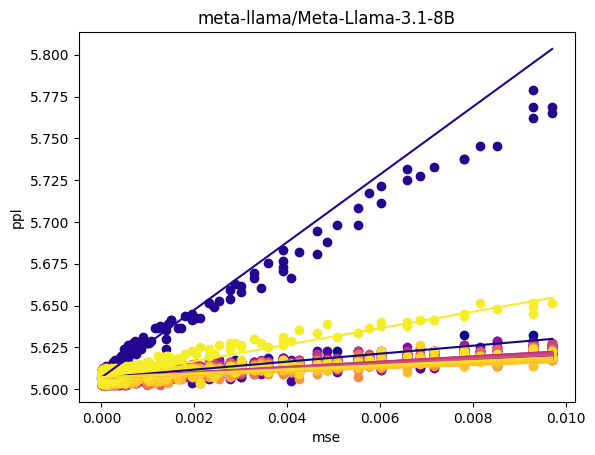

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

plt.scatter([0.0], [BASE_PPL])

for layer_idx in range(32):
# for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer_idx'] == layer_idx]
    to_plot = to_plot[to_plot['mse'] < 0.01]
    # to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / 32))

    grid = np.linspace(0, to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercepts[layer_idx] + grid * slopes[layer_idx], color=cmap(layer_idx / 32))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [14]:
from ortools.linear_solver import pywraplp

def find_grids_with_budget(
    slopes,    # linear coefficients for [layerwise mse -> metric]
    weights,   # linear coefficients for [layer bitwidth -> total bitwidth] (1 / num_blocks for blockwise)
    budget,    # upper bound on total bitwidth
    grid_bits, # available grid bitwidths
    grid_mses  # available grid mses
) -> tuple[float, list]:
    num_layers = len(slopes)
    num_grids = len(grid_bits)
    assert len(grid_mses) == num_grids
    
    solver = pywraplp.Solver.CreateSolver("CP-SAT")

    x = {(j, i) : solver.BoolVar("name") for i in range(num_grids) for j in range(num_layers)}
    
    for j in range(num_layers) : solver.Add(sum(x[(j, i)] for i in range(num_grids)) == 1)
    solver.Add(sum(x[(j, i)] * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids)) <= budget)
    solver.Minimize(sum(x[(j, i)] * slopes[j] * grid_mses[i] for j in range(num_layers) for i in range(num_grids)))

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        avg_bits = sum(x[(j, i)].solution_value() * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids))
        solution = np.asarray([[x[(j, i)].solution_value() for i in range(num_grids)] for j in range(num_layers)])
        indices = np.argwhere(solution == 1.0)
        assert len(indices) == num_layers
        return avg_bits, indices[:,1]
    else:
        raise Exception("Didn't solve")

In [20]:
test_input = torch.randn((1024, 1024), device='cuda')

ok_grids = pd.DataFrame([{
    'name': 'fp16',
    'bits': 16,
    'mse': 0.0, # should be zero, but it breaks solver
}] + [{
    'name': f'hqq-{bits}',
    'bits': bits,
    'mse': (((quantize_dequantize_hqq(test_input, bits) - test_input).norm() ** 2) / (test_input.norm() ** 2)).item(),
} for bits in [8, 4, 3, 2, 1]])

ok_grids

,name,bits,mse
0,fp16,16,0.000000
1,hqq-8,8,0.000028
2,hqq-4,4,0.008050
3,hqq-3,3,0.037035
4,hqq-2,2,0.202752
5,hqq-1,1,2.738639


In [21]:
grid_names=ok_grids['name'].values
grid_bits=ok_grids['bits'].values
grid_mses=ok_grids['mse'].values

solution_size, solution_idxs = find_grids_with_budget(
    slopes,
    np.ones((32,)) / 32,
    budget=8,
    grid_bits=ok_grids['bits'].values,
    grid_mses=ok_grids['mse'].values,
)

print(f'{solution_size} bits')

8.0 bits


In [22]:
def get_solution(n_bits = 8):
    solution_size, solution_idxs = find_grids_with_budget(
        slopes,
        np.ones((32,)) / 32,
        budget=n_bits,
        grid_bits=ok_grids['bits'].values,
        grid_mses=ok_grids['mse'].values,
    )

    solution_pred_err = sum([scale * ok_grids['mse'].values[solution_idx] for solution_idx, scale in zip(solution_idxs, slopes)])

    return solution_size, solution_pred_err, solution_idxs

In [23]:
grid = np.linspace(2.0, 8.0, num=40)

hqq_pred_lines = []

for n_bits in tqdm.tqdm(grid):
    solution_size, solution_pred_err, solution_idxs = get_solution(n_bits)
    hqq_pred_lines.append({
        'solution_size': solution_size,
        'solution_pred_err': solution_pred_err,
    })

hqq_pred_df = pd.DataFrame(hqq_pred_lines)

100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


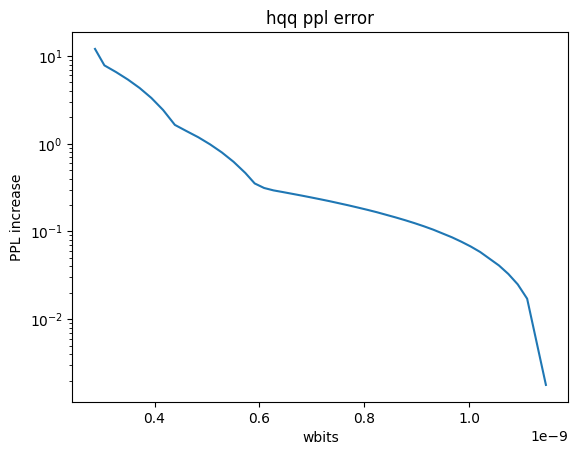

In [25]:
plt.title('hqq ppl error')
plt.ylabel('PPL increase')
plt.xlabel('wbits')
plt.plot(hqq_pred_df['solution_size'] / total_params, hqq_pred_df['solution_pred_err'])
plt.yscale('log')

plt.show()

In [26]:
def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

In [27]:
model_pt = model_pt.cuda()

In [28]:
BASELINE_PPL = eval_ppl(model_pt)['wikitext2']
BASELINE_PPL

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.45 `position_ids` will be removed and `position_embeddings` will be mandatory.


5.606260776519775

In [29]:
model_state_dict = model_pt.state_dict()

In [30]:
layer_names = [f"model.layers.{i}.self_attn.{name}_proj" for i in range(32) for name in ("q","k","v","o")] + \
    [f"model.layers.{i}.mlp.{name}_proj" for i in range(32) for name in ("gate","up","down")]

In [34]:
state_dicts = {
    "fp16": model_state_dict
} | {
    f"hqq-{bits}": {layer: quantize_dequantize_hqq(model_state_dict[f'{layer}.weight'], bits) for layer in tqdm.tqdm(layer_names)} for bits in [8, 4, 3, 2, 1]
}

100%|██████████| 224/224 [00:50<00:00,  4.41it/s]


array(['fp16', 'hqq-8', 'hqq-4', 'hqq-3', 'hqq-2', 'hqq-1'], dtype=object)

In [37]:
import tqdm
import copy

@torch.no_grad()
def eval_quantized_model(solution_idxs):
    quantized_model = copy.deepcopy(model_pt)
    
    for i, quant_idx in enumerate(solution_idxs):
        for layer_name in [f"model.layers.{i}.self_attn.{name}_proj" for name in ("q","k","v","o")] + \
            [f"model.layers.{i}.mlp.{name}_proj" for name in ("gate","up","down")]:
            layer = get_module_by_path(quantized_model, layer_name)
            weight = state_dicts[grid_names[quant_idx]][layer_name].clone().detach()
            layer.weight.data = weight.to(torch.bfloat16)

    return eval_ppl(quantized_model)['wikitext2'] - BASELINE_PPL

In [38]:
grid = np.linspace(2.0, 8.0, num=40)

hqq_real_lines = []

for n_bits in tqdm.tqdm(grid):
    solution_size, solution_pred_err, solution_idxs = get_solution(n_bits)
    real_err = eval_quantized_model(solution_idxs)
    hqq_real_lines.append({
        'solution_size': solution_size,
        'solution_pred_err': solution_pred_err,
        'solution_real_err': real_err,
    })

100%|██████████| 40/40 [39:54<00:00, 59.87s/it]


In [39]:
hqq_real_df = pd.DataFrame(hqq_real_lines)

In [40]:
hqq_real_df['solution_size']

0     2.00000
1     2.12500
2     2.28125
3     2.43750
4     2.59375
5     2.75000
6     2.90625
7     3.06250
8     3.21875
9     3.37500
10    3.53125
11    3.68750
12    3.84375
13    4.00000
14    4.12500
15    4.25000
16    4.37500
17    4.50000
18    4.75000
19    4.87500
20    5.00000
21    5.12500
22    5.37500
23    5.50000
24    5.62500
25    5.75000
26    6.00000
27    6.12500
28    6.25000
29    6.37500
30    6.50000
31    6.75000
32    6.87500
33    7.00000
34    7.12500
35    7.37500
36    7.50000
37    7.62500
38    7.75000
39    8.00000
Name: solution_size, dtype: float64

In [1]:
plt.scatter(hqq_real_df['solution_pred_err'], hqq_real_df['solution_real_err'])
plt.plot(hqq_real_df['solution_pred_err'], hqq_real_df['solution_real_err'])
plt.xlabel('pred ppl err')
plt.ylabel('real ppl err')
plt.xlim(0, 8)
plt.ylim(0, 8)

NameError: name 'plt' is not defined

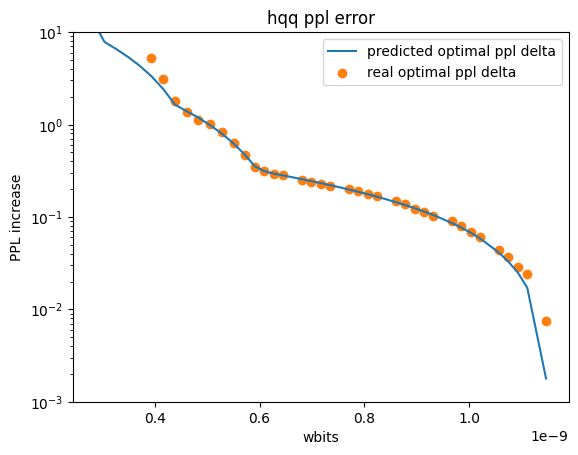

In [49]:
import matplotlib as mpl

plt.title('hqq ppl error')
plt.ylabel('PPL increase')
plt.xlabel('wbits')
plt.plot(hqq_pred_df['solution_size'] / total_params, hqq_pred_df['solution_pred_err'], label='predicted optimal ppl delta')
plt.scatter(hqq_real_df['solution_size'] / total_params, hqq_real_df['solution_real_err'], color=mpl.colormaps['tab10'](1), label='real optimal ppl delta')
plt.ylim(1e-3, 10)
plt.yscale("log")

plt.legend()

plt.show()

In [50]:
hqq_pred_df.to_csv('blockwise_hqq_pred_df.csv')
hqq_real_df.to_csv('blockwise_hqq_real_df.csv')